# финальный проект.Промышленность

<div style=" padding: 30px 25px; border: 3px #FFBF73 solid">
<p style="font-weight: 900; text-align: center;">  Задача  помочь заказчику уменьшить расход электроэнергии на производстве с помощью ML модели.

 - нужно загрузить данные из БД SQL 
 - обработать,проанализировать данные
 -  на основе анализа создать ML модель для предсказания температуры сплава на разных этапах производства

<div style=" padding: 30px 25px; border: 3px #FFBF73 solid">
<p style="font-weight: 900; text-align: center;"> Описание данных </p>


__Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц__:
    
    steel.data_arc — данные об электродах;
    steel.data_bulk — данные об объёме сыпучих материалов;
    steel.data_bulk_time — данные о времени подачи сыпучих материалов;
    steel.data_gas — данные о продувке сплава газом;
    steel.data_temp — данные об измерениях температуры;
    steel.data_wire — данные об объёме проволочных материалов;
    steel.data_wire_time — данные о времени подачи проволочных материалов.
    
__key — номер партии. В таблицах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.__
    
__Таблица steel.data_arc__
   - BeginHeat — время начала нагрева;
   - EndHeat — время окончания нагрева;
   - ActivePower — значение активной мощности;
   - ReactivePower — значение реактивной мощности.
    
    
__Таблица steel.data_bulk__
   - Bulk1 … Bulk15 — объём подаваемого материала.
    
__Таблица steel.data_bulk_time__
   - Bulk1 … Bulk15 — время подачи материала.
    
    
__Таблица steel.data_gas__
   - gas — объём подаваемого газа.
    
    
__Таблица steel.data_temp__
   - MesaureTime — время замера;
   - Temperature — значение температуры.
    
    
__Таблица steel.data_wire__
   - Wire1 … Wire15 — объём подаваемых проволочных материалов.
    
    
__Таблица steel.data_wire_time__
   - Wire1 … Wire15 — время подачи проволочных материалов.

<div style="font-size:30px ;padding: 30px 25px; background-color:#7AD1FF ;solid;font-weight:400">
    
<p style="font-weight: bold; text-align: center;">  импорт библиотек </p>

In [1]:
from IPython.core.display import display, HTML


import pandas as pd
import numpy as np
from sqlalchemy import create_engine 
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.init as init
import torch.nn as nn
from torch import tensor
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_absolute_error,r2_score

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,Lasso
from catboost import CatBoostRegressor

import warnings

In [2]:
display(HTML("<style>.container { width:100% !important; }</style>"))

warnings.filterwarnings("ignore")

SEED = 141123
torch.manual_seed(141123);

<div style="font-size:30px ;padding: 30px 25px; background-color:#7AD1FF ;solid;font-weight:400">
<p style="font-weight: bold; text-align: center;">   функции

In [3]:
def data_analis (df,  i  = True,
                  h  = True,
                  ds = True,
                  dp = True,
                  isna=True):
    if i == True:
        i=df.info()
        i

    if h == True:
        h = df.head()
        display(h)

    if ds == True:
        ds = df.describe()
        display(ds)
    print()
    if dp == True:
        dp = df.duplicated().sum()
        print('дубликаты:',dp)

    if isna == True:
        isna = df.isna().sum()
        miss = df.isna().sum() * 100 / len(df)
        display(pd.DataFrame({'пропуски':isna,'% потерь':miss},dtype=int))

In [4]:
def merger_by_key_inner(t1, t2):
    
    #merge dfs
    merged = t1.merge(right=t2,
            how='inner',
            on='key')
    
    return merged

<div style="font-size:30px ;padding: 30px 25px; background-color:#7AD1FF ;solid;font-weight:400">
<p style="font-weight: bold; text-align: center;"> Глава 1. загрузка и просмотр данных

In [5]:

db_config = {
'user': 'praktikum_student',# имя пользователя
'pwd': 'Sdf4$2;d-d30pp',# пароль
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,# порт подключения
'db': 'data-science-final'# название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [6]:
engine = create_engine(connection_string) 

In [7]:
query = '''
SELECT table_name
FROM information_schema.tables
WHERE table_type = 'BASE TABLE' AND table_schema= 'steel'
'''
sample_df=pd.read_sql_query(query, con=engine) 

In [8]:
display(sample_df)

,table_name
0,data_arc
1,data_bulk
2,data_bulk_time
3,data_gas
4,data_temp
5,data_wire
6,data_wire_time


In [9]:
query = '''
SELECT *
FROM steel.data_arc
'''

arc = pd.read_sql_query(query, con=engine) 

In [10]:
data_analis(arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397


,key,ActivePower,ReactivePower
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388



дубликаты: 0


,пропуски,% потерь
key,0,0
BeginHeat,0,0
EndHeat,0,0
ActivePower,0,0
ReactivePower,0,0


In [11]:
query = '''
SELECT *
FROM steel.data_bulk
'''

bulk = pd.read_sql_query(query, con=engine) 

In [12]:
data_analis(bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



дубликаты: 0


,пропуски,% потерь
key,0,0
Bulk 1,2877,91
Bulk 2,3107,99
Bulk 3,1831,58
Bulk 4,2115,67
Bulk 5,3052,97
Bulk 6,2553,81
Bulk 7,3104,99
Bulk 8,3128,99
Bulk 9,3110,99


In [13]:
query = '''
SELECT *
FROM steel.data_bulk_time
'''

bulk_time = pd.read_sql_query(query, con=engine)

In [14]:
data_analis(bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000



дубликаты: 0


,пропуски,% потерь
key,0,0
Bulk 1,2877,91
Bulk 2,3107,99
Bulk 3,1831,58
Bulk 4,2115,67
Bulk 5,3052,97
Bulk 6,2553,81
Bulk 7,3104,99
Bulk 8,3128,99
Bulk 9,3110,99


In [15]:
query = '''
SELECT *
FROM steel.data_gas
'''

gas = pd.read_sql_query(query, con=engine) 


In [16]:
data_analis(gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040



дубликаты: 0


,пропуски,% потерь
key,0,0
gas,0,0


In [17]:
query = '''
SELECT *
FROM steel.data_temp
'''

temp = pd.read_sql_query(query, con=engine) 

In [18]:
data_analis(temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0


,key,Temperature
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000



дубликаты: 0


,пропуски,% потерь
key,0,0
MesaureTime,0,0
Temperature,2901,18


In [19]:
query = '''
SELECT *
FROM steel.data_wire
'''

wire = pd.read_sql_query(query, con=engine) 

In [20]:
data_analis(wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



дубликаты: 0


,пропуски,% потерь
key,0,0
Wire 1,26,0
Wire 2,2002,64
Wire 3,3018,97
Wire 4,3067,99
Wire 5,3080,99
Wire 6,3008,97
Wire 7,3070,99
Wire 8,3062,99
Wire 9,3052,99


In [21]:
query = '''
SELECT *
FROM steel.data_wire_time
'''

wire_time = pd.read_sql_query(query, con=engine) 

In [22]:
data_analis(wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000



дубликаты: 0


,пропуски,% потерь
key,0,0
Wire 1,26,0
Wire 2,2002,64
Wire 3,3018,97
Wire 4,3067,99
Wire 5,3080,99
Wire 6,3008,97
Wire 7,3070,99
Wire 8,3062,99
Wire 9,3052,99


<div style="padding: 30px 25px; border: 3px #7AD1FF solid">
    
<p style="font-weight: bold; text-align: center;"> вывод <p>
    
 - данные были успешно загруженны
  - в таблице data_arc наблюдаются аномальные значения в столбцах ActivePower и ReactivePower, скорее всего эти мощьности должны
    быть в пределе от 0 до 1, но не как ни в передах от -715 до 3. Также нужно изменить тип данных в столбцах BeginHeat и  EndHeat
    на datetime
  - в таблице data_bulk присутствуют дубликаты, а также Огромноге количество пропусков, эти пропуски можно заменить 0 т.к. в данной таблице пропуск означает, что материал не подавался .
  - в таблице data_bulk_time тоже много пропусков, думаю их можно тоже заменить на 0.
  - в таблице data_gas все хорошо, но судя по всему есть аномальные значения
  - в таблице data_temp присутствуют дубликаты и отсутствут некоторые значения температур
  - в таблице data_wire какое то невероятное количество пропусов, хоть бери и удаляй все столбы с 3 по 9. Присутствуют дубликаты и аномалии (по моему мнению обьем материала дан в процентах т.е. от 0 до 100)
  - в таблице data_wire_time ситуация не лучше, тоже много пропусов и тоже присутствуют дубликаты.

<div style="font-size:30px ;padding: 30px 25px; background-color:#7AD1FF ;solid;font-weight:400">
<p style="font-weight: bold; text-align: center;"> Глава 2. Обработка и исследовательский анализ

In [23]:
print('Кол-во строк до удаления:', len(arc))

arc = arc.drop(index=arc[arc['ReactivePower'] < 0].index)

print('Кол-во после удаления:', len(arc))

Кол-во строк до удаления: 14876
Кол-во после удаления: 14875


In [24]:
arc['BeginHeat'] = pd.to_timedelta(arc['BeginHeat'].astype(str))
arc['EndHeat']=pd.to_timedelta(arc['EndHeat'].astype(str))

In [25]:
arc['FullPower']= np.sqrt(arc['ReactivePower']**2+arc['ActivePower']**2)

In [26]:
arc

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,FullPower
0,1,0 days 11:02:14,0 days 11:06:02,0.976059,0.687084,1.193639
1,1,0 days 11:07:28,0 days 11:10:33,0.805607,0.520285,0.959010
2,1,0 days 11:11:44,0 days 11:14:36,0.744363,0.498805,0.896038
3,1,0 days 11:18:14,0 days 11:24:19,1.659363,1.062669,1.970470
4,1,0 days 11:26:09,0 days 11:28:37,0.692755,0.414397,0.807239
...,...,...,...,...,...,...
14871,3241,0 days 03:58:58,0 days 04:01:35,0.533670,0.354439,0.640648
14872,3241,0 days 04:05:04,0 days 04:08:04,0.676604,0.523631,0.855559
14873,3241,0 days 04:16:41,0 days 04:19:45,0.733899,0.475654,0.874560
14874,3241,0 days 04:31:51,0 days 04:32:48,0.220694,0.145768,0.264489


In [27]:
bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [28]:
bulk=bulk.drop_duplicates()
bulk=bulk.drop(['Bulk 1','Bulk 2','Bulk 5','Bulk 7','Bulk 8','Bulk 9','Bulk 10','Bulk 11','Bulk 13'],axis=1)
bulk_time=bulk_time.drop_duplicates()
bulk_time=bulk_time.drop(['Bulk 1','Bulk 2','Bulk 5','Bulk 7','Bulk 8','Bulk 9','Bulk 10','Bulk 11','Bulk 13'],axis=1)
bulk=bulk.fillna(0)
bulk_time=bulk_time.fillna(0)

print(bulk.isna().sum(),
      bulk_time.isna().sum())


key        0
Bulk 3     0
Bulk 4     0
Bulk 6     0
Bulk 12    0
Bulk 14    0
Bulk 15    0
dtype: int64 key        0
Bulk 3     0
Bulk 4     0
Bulk 6     0
Bulk 12    0
Bulk 14    0
Bulk 15    0
dtype: int64


In [29]:
bulk_time['Bulk 3']=pd.to_timedelta(bulk_time['Bulk 3'].astype(str))
bulk_time['Bulk 4']=pd.to_timedelta(bulk_time['Bulk 4'].astype(str))
bulk_time['Bulk 6']=pd.to_timedelta(bulk_time['Bulk 6'].astype(str))
bulk_time['Bulk 12']=pd.to_timedelta(bulk_time['Bulk 12'].astype(str))
bulk_time['Bulk 14']=pd.to_timedelta(bulk_time['Bulk 14'].astype(str))
bulk_time['Bulk 15']=pd.to_timedelta(bulk_time['Bulk 15'].astype(str))

In [30]:
temp= temp.dropna()
temp.isna().sum()
temp = temp.drop(index=temp[temp['Temperature']<1500].index)

In [31]:
temp['MesaureTime']=pd.to_datetime(temp['MesaureTime'],format='%H:%M:%S')

In [32]:
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [33]:
wire=wire.drop_duplicates()
wire=wire.drop(['Wire 3','Wire 4','Wire 5','Wire 6','Wire 7','Wire 8','Wire 9'],axis=1)
wire_time= wire_time.drop_duplicates()
wire_time=wire_time.drop(['Wire 3','Wire 4','Wire 5','Wire 6','Wire 7','Wire 8','Wire 9'],axis=1)
wire=wire.fillna(0)
wire_time=wire_time.fillna(0)

print(wire.isna().sum(),
      wire_time.isna().sum())

key       0
Wire 1    0
Wire 2    0
dtype: int64 key       0
Wire 1    0
Wire 2    0
dtype: int64


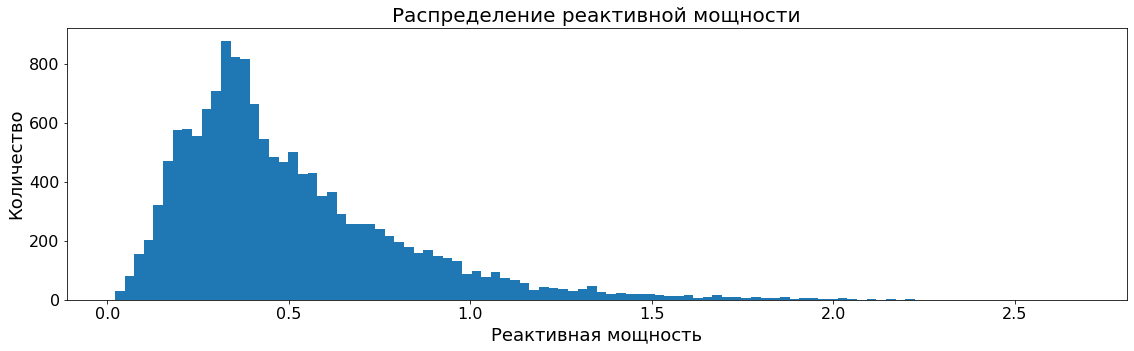

In [34]:
data = arc['ReactivePower']

plt.figure(figsize=(19,5))
plt.hist(data, bins=100)
plt.xlabel('Реактивная мощность', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Количество', fontsize=18)
plt.yticks(fontsize=16)
plt.title('Распределение реактивной мощности', fontsize=20)
plt.show()

In [35]:
wire_time['Wire 1']=pd.to_timedelta(wire_time['Wire 1'].astype(str))
wire_time['Wire 2']=pd.to_timedelta(wire_time['Wire 2'].astype(str))

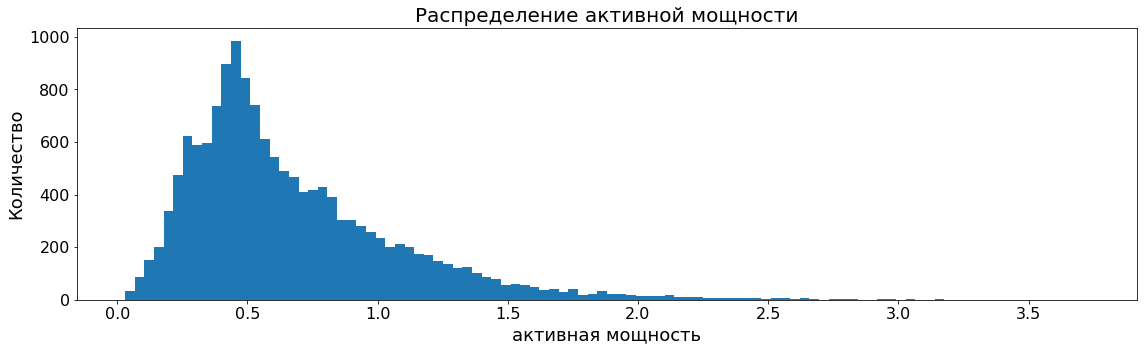

In [36]:
data = arc['ActivePower']

plt.figure(figsize=(19,5))
plt.hist(data, bins=100)
plt.xlabel('активная мощность', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Количество', fontsize=18)
plt.yticks(fontsize=16)
plt.title('Распределение активной мощности', fontsize=20)
plt.show()

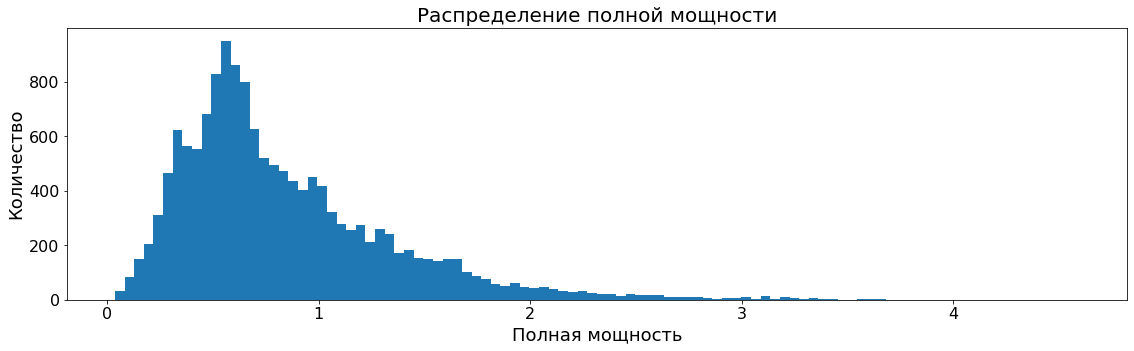

In [37]:
data = arc['FullPower']

plt.figure(figsize=(19,5))
plt.hist(data, bins=100)
plt.xlabel('Полная мощность', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Количество', fontsize=18)
plt.yticks(fontsize=16)
plt.title('Распределение полной мощности', fontsize=20)
plt.show()

In [38]:
arc = arc.drop(['ActivePower','ReactivePower'], axis=1)
arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype          
---  ------     --------------  -----          
 0   key        14875 non-null  int64          
 1   BeginHeat  14875 non-null  timedelta64[ns]
 2   EndHeat    14875 non-null  timedelta64[ns]
 3   FullPower  14875 non-null  float64        
dtypes: float64(1), int64(1), timedelta64[ns](2)
memory usage: 581.1 KB


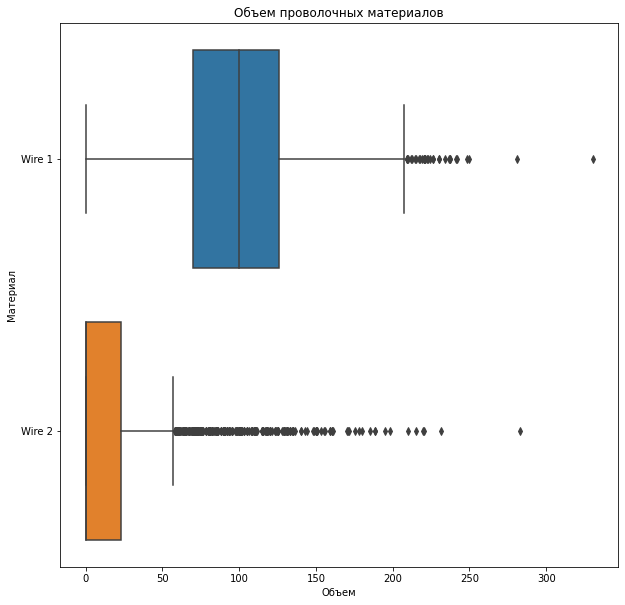

In [39]:
key= wire.drop('key',axis=1)
plt.figure(figsize=(10,10))
sns.boxplot(data=key, orient="h")
plt.title('Объем проволочных материалов')
plt.xlabel('Объем')
plt.ylabel('Материал')

plt.show()

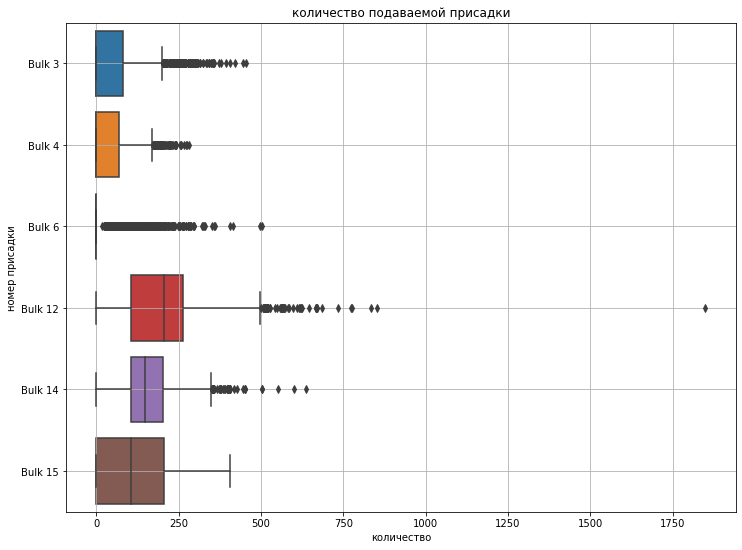

In [40]:
key=bulk.drop('key',axis=1)
plt.figure(figsize=(12,9))
sns.boxplot(data=key,orient="h")
plt.title('количество подаваемой присадки')
plt.xlabel('количество')
plt.ylabel('номер присадки')
plt.grid();

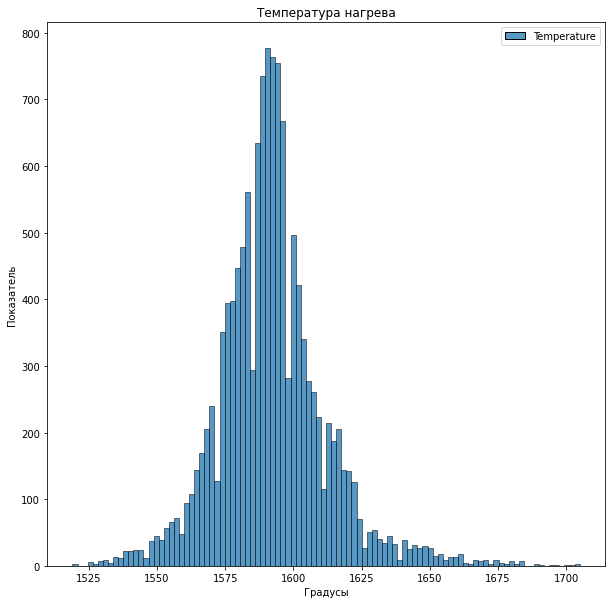

In [41]:
key=temp.drop('key',axis=1)
plt.figure(figsize=(10,10))
sns.histplot(data=key,bins=100)
plt.title('Температура нагрева')
plt.xlabel('Градусы')
plt.ylabel('Показатель')

plt.show()

In [42]:
arc['warm_time'] = (arc['EndHeat'] - arc['BeginHeat']).dt.seconds
arc = arc.drop(['BeginHeat','EndHeat'], axis=1)
arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   key        14875 non-null  int64  
 1   FullPower  14875 non-null  float64
 2   warm_time  14875 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 464.8 KB


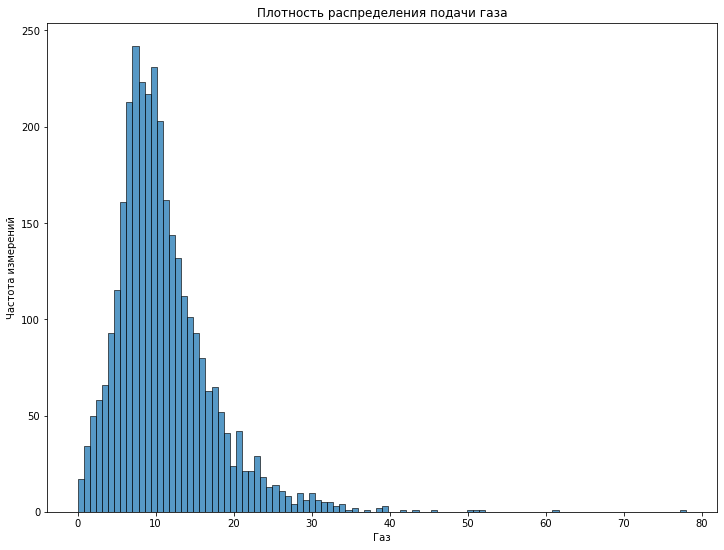

In [43]:
plt.figure(figsize=(12, 9))
sns.histplot(gas['gas'], bins=100)
plt.title('Плотность распределения подачи газа')
plt.xlabel('Газ')
plt.ylabel('Частота измерений')
plt.show()

In [44]:
final_data_temp = temp.groupby('key').agg(['first', 'last']).reset_index()

final_data_temp.columns = ['key', 'first_temp_ts', 'finish_temp_ts', 'first_temp', 'last_temp']
final_data_temp['time_temp_diff'] = final_data_temp['finish_temp_ts'] - final_data_temp['first_temp_ts']
final_data_temp['time_temp_diff'] = final_data_temp['time_temp_diff'].dt.seconds
final_data_temp = final_data_temp.query('key < 2500')
final_data_temp

,key,first_temp_ts,finish_temp_ts,first_temp,last_temp,time_temp_diff
0,1,1900-01-01 11:16:18,1900-01-01 11:30:39,1571.0,1613.0,861
1,2,1900-01-01 11:37:27,1900-01-01 11:59:12,1581.0,1602.0,1305
2,3,1900-01-01 12:13:17,1900-01-01 12:34:57,1596.0,1599.0,1300
3,4,1900-01-01 12:52:57,1900-01-01 12:59:25,1601.0,1625.0,388
4,5,1900-01-01 13:23:19,1900-01-01 13:36:01,1576.0,1602.0,762
...,...,...,...,...,...,...
2472,2495,1900-01-01 00:35:45,1900-01-01 00:54:42,1570.0,1591.0,1137
2473,2496,1900-01-01 01:02:54,1900-01-01 01:29:52,1554.0,1591.0,1618
2474,2497,1900-01-01 01:41:53,1900-01-01 01:53:50,1571.0,1589.0,717
2475,2498,1900-01-01 02:03:49,1900-01-01 02:25:31,1591.0,1594.0,1302


In [45]:
final_data_temp=final_data_temp.drop(['first_temp_ts', 'finish_temp_ts'],axis=1)

In [46]:
#temp['rank'] = temp.groupby('key')['MesaureTime'].rank(ascending=False)
#temp[temp['key'].isin([1,2])]

In [47]:
#temp_asc = temp.copy() 
#temp_asc['rank'] = temp_asc.groupby('key')['MesaureTime'].rank(ascending=True)

#temp_first = temp_asc[temp_asc['rank'] == 1].drop(columns=['MesaureTime', 'rank'])
#temp_first.columns = ['key', 'temp_first']

#temp_last = temp[temp['rank'] == 1].drop(columns=['MesaureTime', 'rank'],axis=1)
#temp_last.columns = ['key', 'temp_last']
#display(temp_first.head(),temp_last.head())

In [48]:
#temp_df= temp_first.merge(right=temp_last,how='left',on='key')

In [49]:
#temp_df

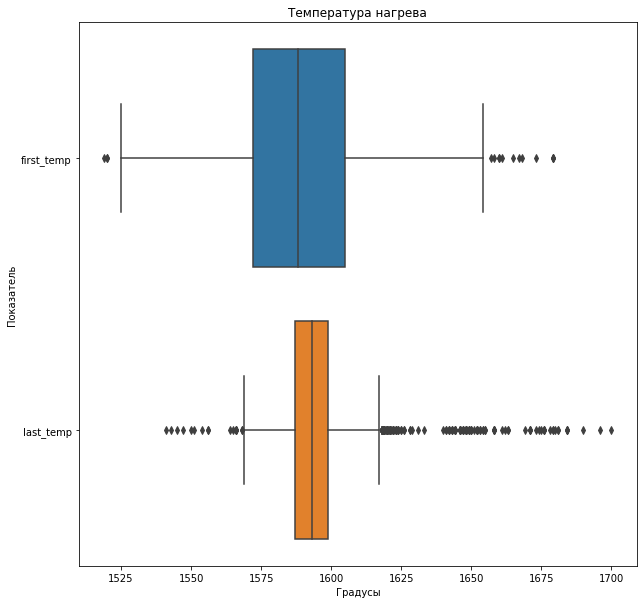

In [50]:
plt.figure(figsize=(10,10))
sns.boxplot(data=final_data_temp.drop(columns=['key','time_temp_diff']), orient="h")
plt.title('Температура нагрева')
plt.xlabel('Градусы')
plt.ylabel('Показатель')

plt.show()

In [51]:
arc = arc.groupby('key')['FullPower'].sum()
arc= arc.reset_index()

In [52]:
df_result = pd.DataFrame()

if df_result.empty:
    df_result = merger_by_key_inner(final_data_temp, arc)
    df_result = merger_by_key_inner(df_result, bulk)
    df_result = merger_by_key_inner(df_result, wire)
    df_result = merger_by_key_inner(df_result, gas)
data_analis(df_result)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             2329 non-null   int64  
 1   first_temp      2329 non-null   float64
 2   last_temp       2329 non-null   float64
 3   time_temp_diff  2329 non-null   int64  
 4   FullPower       2329 non-null   float64
 5   Bulk 3          2329 non-null   float64
 6   Bulk 4          2329 non-null   float64
 7   Bulk 6          2329 non-null   float64
 8   Bulk 12         2329 non-null   float64
 9   Bulk 14         2329 non-null   float64
 10  Bulk 15         2329 non-null   float64
 11  Wire 1          2329 non-null   float64
 12  Wire 2          2329 non-null   float64
 13  gas             2329 non-null   float64
dtypes: float64(12), int64(2)
memory usage: 272.9 KB


,key,first_temp,last_temp,time_temp_diff,FullPower,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,gas
0,1,1571.0,1613.0,861,5.826395,0.0,43.0,0.0,206.0,150.0,154.0,60.059998,0.00000,29.749986
1,2,1581.0,1602.0,1305,3.649216,0.0,73.0,0.0,206.0,149.0,154.0,96.052315,0.00000,12.555561
2,3,1596.0,1599.0,1300,2.989534,0.0,34.0,0.0,205.0,152.0,153.0,91.160157,0.00000,28.554793
3,4,1601.0,1625.0,388,3.814962,0.0,81.0,0.0,207.0,153.0,154.0,89.063515,0.00000,18.841219
4,5,1576.0,1602.0,762,4.035758,0.0,78.0,0.0,203.0,151.0,152.0,89.238236,9.11456,5.413692


,key,first_temp,last_temp,time_temp_diff,FullPower,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,gas
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,1251.832546,1587.386003,1593.365393,1898.290253,3.941677,47.348218,37.303564,22.430228,208.415629,153.853585,119.952769,102.443601,17.609859,11.375600
std,714.762400,23.619841,11.200915,1322.054556,1.779518,75.310430,58.643238,55.790873,157.062272,81.404354,84.640443,43.539993,33.624771,6.392041
min,1.000000,1519.000000,1541.000000,234.000000,0.257637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399
25%,630.000000,1571.000000,1587.000000,1215.000000,2.735080,0.000000,0.000000,0.000000,105.000000,105.000000,0.000000,73.207679,0.000000,7.282948
50%,1255.000000,1587.000000,1593.000000,1634.000000,3.773603,0.000000,0.000000,0.000000,206.000000,149.000000,107.000000,101.119201,0.000000,10.100950
75%,1868.000000,1603.000000,1598.000000,2290.000000,4.892791,80.000000,77.000000,0.000000,282.000000,204.000000,204.000000,128.091599,23.102560,14.216688
max,2499.000000,1660.000000,1653.000000,23537.000000,21.564771,454.000000,281.000000,503.000000,1849.000000,636.000000,405.000000,330.314424,282.780152,77.995040



дубликаты: 0


,пропуски,% потерь
key,0,0
first_temp,0,0
last_temp,0,0
time_temp_diff,0,0
FullPower,0,0
Bulk 3,0,0
Bulk 4,0,0
Bulk 6,0,0
Bulk 12,0,0
Bulk 14,0,0


In [53]:
df_result.shape

(2329, 14)

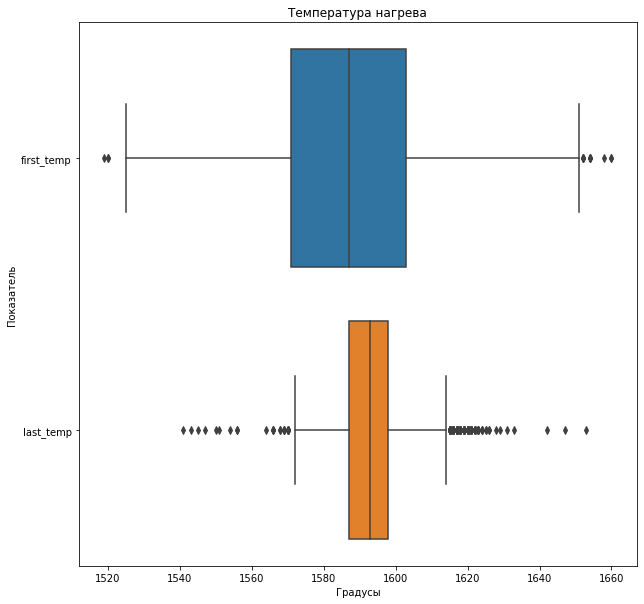

In [54]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df_result[['first_temp','last_temp']], orient="h")
plt.title('Температура нагрева')
plt.xlabel('Градусы')
plt.ylabel('Показатель')

plt.show()

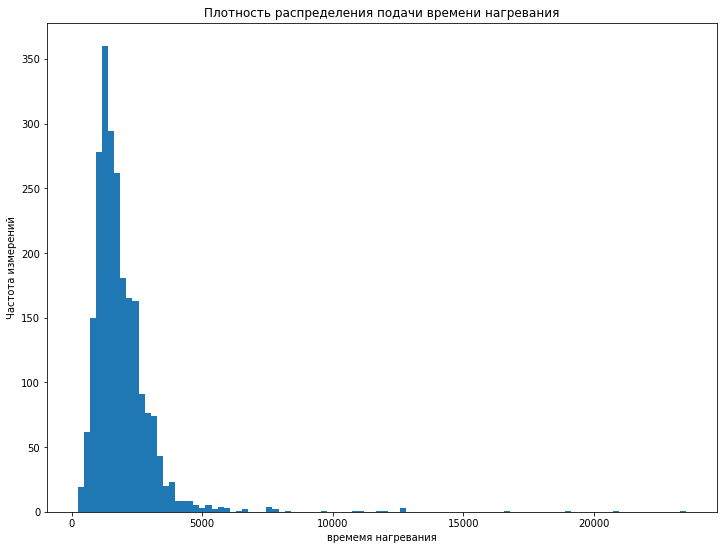

In [55]:
plt.figure(figsize=(12, 9))
plt.hist(df_result['time_temp_diff'], bins=100)
plt.title('Плотность распределения подачи времени нагревания')
plt.xlabel('времемя нагревания')
plt.ylabel('Частота измерений')
plt.show()

In [56]:
df_result=df_result.drop(df_result[df_result['time_temp_diff']>13000].index)

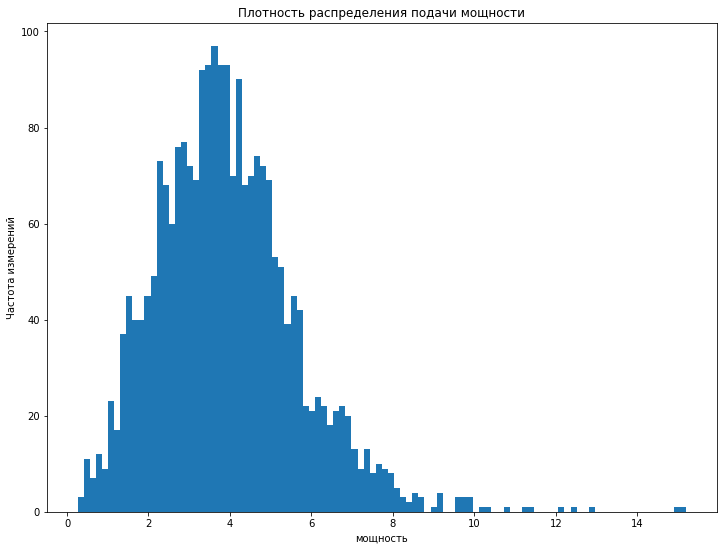

In [57]:
plt.figure(figsize=(12, 9))
plt.hist(df_result['FullPower'], bins=100)
plt.title('Плотность распределения подачи мощности')
plt.xlabel('мощность')
plt.ylabel('Частота измерений')
plt.show()

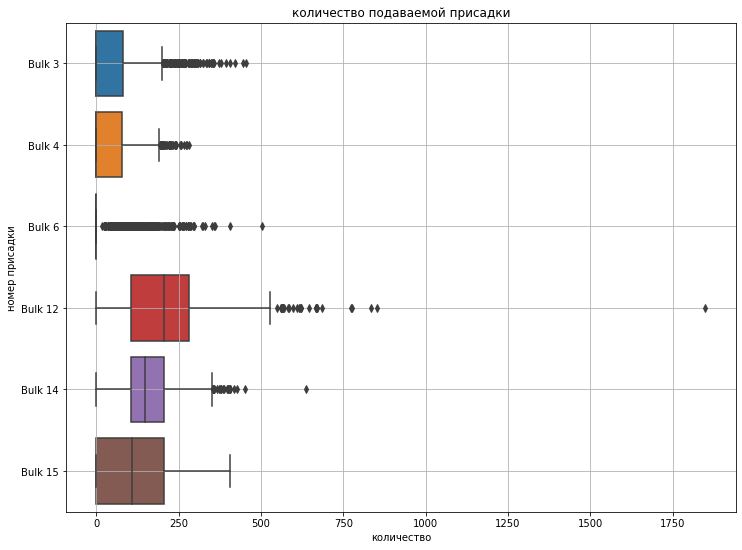

In [58]:
key=df_result.iloc[:,5:11]
plt.figure(figsize=(12,9))
sns.boxplot(data=key,orient="h")
plt.title('количество подаваемой присадки')
plt.xlabel('количество')
plt.ylabel('номер присадки')
plt.grid();

In [59]:
df_result=df_result.drop(df_result[df_result['Bulk 12']>700].index)

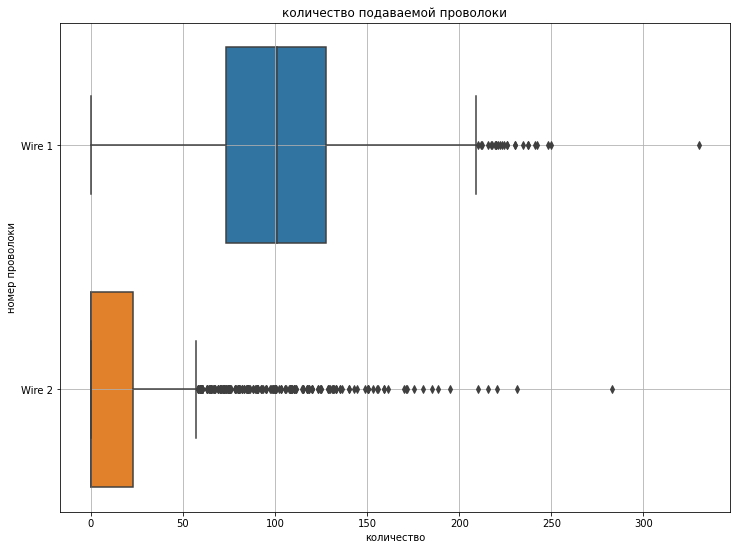

In [60]:
key=df_result.iloc[:,11:13]
plt.figure(figsize=(12,9))
sns.boxplot(data=key,orient="h")
plt.title('количество подаваемой проволоки')
plt.xlabel('количество')
plt.ylabel('номер проволоки')
plt.grid();

In [61]:
df_result=df_result.drop(df_result[df_result['Wire 1']>250].index)
df_result=df_result.drop(df_result[df_result['Wire 2']>250].index)

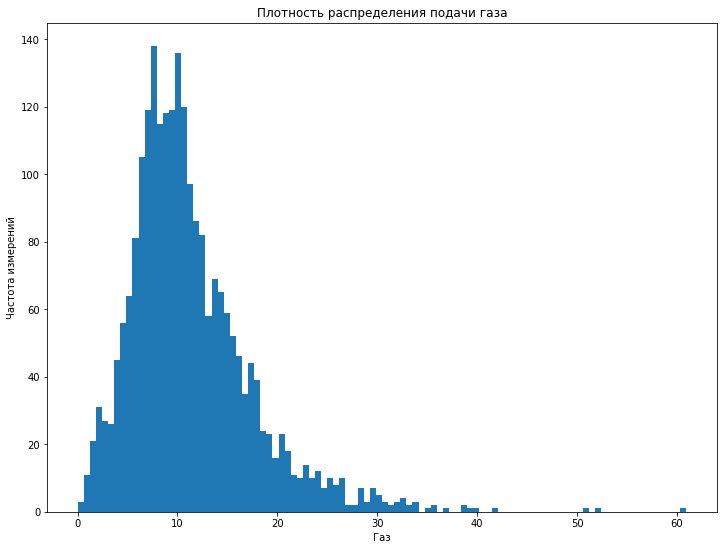

In [62]:
plt.figure(figsize=(12, 9))
plt.hist(df_result['gas'], bins=100)
plt.title('Плотность распределения подачи газа')
plt.xlabel('Газ')
plt.ylabel('Частота измерений')
plt.show()

In [63]:
df_result=df_result.drop(df_result[df_result['gas']>41].index)

In [64]:
df_result.shape

(2314, 14)

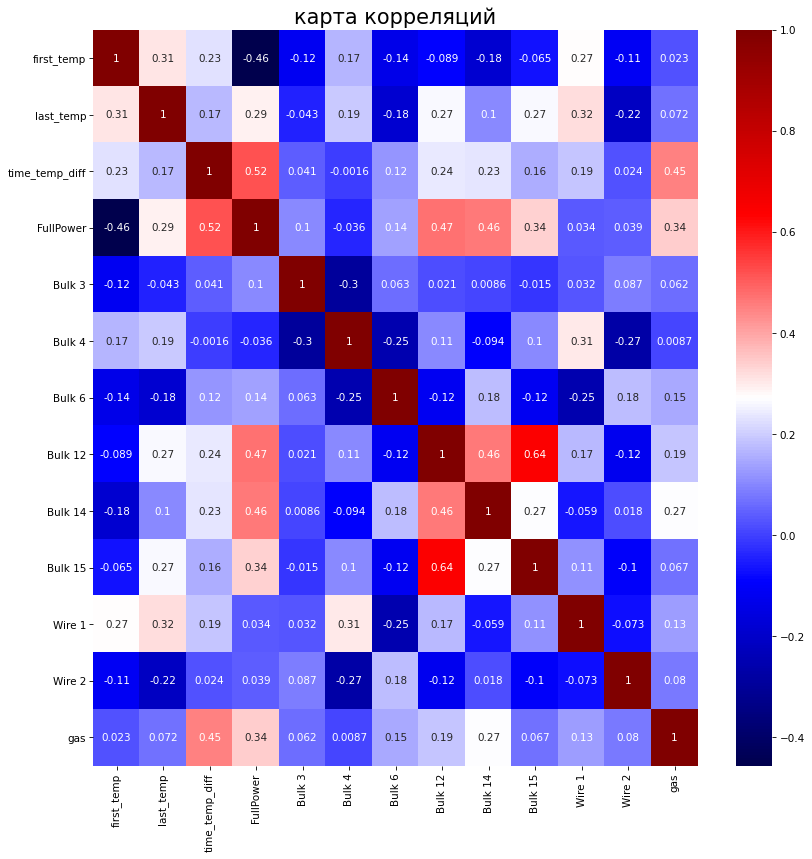

In [65]:
key= df_result.drop('key',axis=1)
plt.figure(figsize=(13, 13),dpi=75)
plt.title('карта корреляций',size=20)
sns.heatmap(key.corr(), annot = True, cmap='seismic');

<div style="padding: 30px 25px; border: 3px #7AD1FF solid">
    
<p style="font-weight: bold; text-align: center;"> вывод <p>

- обработали данные
    - избавились от аномалий 
    - заполнили пропуски 0
    - удалили лишние стобци в которых % потерь был более 80
    - создали новые данные по температуре, времени нагрева, потребляеиой мощьности
    - привели данные со временем в тип timedelta
- обьединили данные в общюю таблицу
- создали карту корреляций
---
- видна зависимость температуры и количества подаваемой проволоки под номером 1
- количество потребляемой мощьности почти на прмямую зависит от времени нагрева
- есть зависимость между количеством газа и количеством материала под номером 14
- сильно видна зависимость между количеством материала 12 и 15
- проволока под номером 1 и количество материала номер 12 
- материал 12 и 14 не ожиданно сильно зависят друг от друга

# разделение данных на выборки для обучения

In [66]:
features = df_result.drop(['last_temp', 'key'], axis=1)
target = df_result['last_temp']
print(f'размер features: {features.shape} размер target : {target.shape}')

размер features: (2314, 12) размер target : (2314,)


In [67]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2314 entries, 0 to 2328
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   first_temp      2314 non-null   float64
 1   time_temp_diff  2314 non-null   int64  
 2   FullPower       2314 non-null   float64
 3   Bulk 3          2314 non-null   float64
 4   Bulk 4          2314 non-null   float64
 5   Bulk 6          2314 non-null   float64
 6   Bulk 12         2314 non-null   float64
 7   Bulk 14         2314 non-null   float64
 8   Bulk 15         2314 non-null   float64
 9   Wire 1          2314 non-null   float64
 10  Wire 2          2314 non-null   float64
 11  gas             2314 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 235.0 KB


In [68]:
x_train, x_test, y_train, y_test = train_test_split(features,
                                                            target,
                                                            test_size=0.25,
                                                            random_state=SEED)


print(f'размер features_train: {x_train.shape} размер target_train : {y_train.shape}')
print(f'размер features_test: {x_test.shape} размер target : {y_test.shape}')

размер features_train: (1735, 12) размер target_train : (1735,)
размер features_test: (579, 12) размер target : (579,)


In [69]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test= scaler.transform(x_test)

<div style="padding: 30px 25px; border: 3px #7AD1FF solid">
<p style="font-weight: bold; text-align: center;"> вывод <p>
    
- разделили данные на тренировойчную и тестовую выборки в процентном соотношении 0.25
- создали отдельную выборку для линейной регресии

<div style="font-size:30px ;padding: 30px 25px; background-color:#7AD1FF ;solid;font-weight:400">
<p style="font-weight: bold; text-align: center;"> глава 3. Обучение моделей

<div style="padding: 30px 25px; border: 3px #7AD1FF solid">
    
<p style="font-weight: bold; text-align: center;"> LinearRegression

In [70]:
grid = {'positive': [True]}

model_lr = LinearRegression()

lr_grid = RandomizedSearchCV(estimator=model_lr,
                                      param_distributions=grid,
                                      cv=10,
                                      verbose=5,
                                       scoring = 'neg_mean_absolute_error',
                                      random_state=SEED)

In [71]:
%%time
lr_grid.fit(x_train,y_train)
final_metrics_LR = lr_grid.best_score_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END .................................positive=True; total time=   0.0s
[CV 2/10] END .................................positive=True; total time=   0.0s
[CV 3/10] END .................................positive=True; total time=   0.0s
[CV 4/10] END .................................positive=True; total time=   0.0s
[CV 5/10] END .................................positive=True; total time=   0.0s
[CV 6/10] END .................................positive=True; total time=   0.0s
[CV 7/10] END .................................positive=True; total time=   0.0s
[CV 8/10] END .................................positive=True; total time=   0.0s
[CV 9/10] END .................................positive=True; total time=   0.0s
[CV 10/10] END ................................positive=True; total time=   0.0s
CPU times: user 170 ms, sys: 0 ns, total: 170 ms
Wall time: 193 ms


In [72]:
print(f'MAE:\n{final_metrics_LR}')

MAE:
-6.623760811535513


<div style="padding: 30px 25px; border: 3px #7AD1FF solid">
    
<p style="font-weight: bold; text-align: center;"> Lasso

In [73]:
grid = {'alpha':[0.1]}

model_lr = Lasso()

lr_lasso_grid = RandomizedSearchCV(estimator=model_lr,
                                      param_distributions=grid,
                                      cv=10,
                                      verbose=5,
                                       scoring = 'neg_mean_absolute_error',
                                      random_state=SEED)

In [74]:
%%time
lr_lasso_grid.fit(x_train,y_train)
final_metrics_LR_lasso = lr_lasso_grid.best_score_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END .....................................alpha=0.1; total time=   0.0s
[CV 2/10] END .....................................alpha=0.1; total time=   0.0s
[CV 3/10] END .....................................alpha=0.1; total time=   0.0s
[CV 4/10] END .....................................alpha=0.1; total time=   0.1s
[CV 5/10] END .....................................alpha=0.1; total time=   0.0s
[CV 6/10] END .....................................alpha=0.1; total time=   0.0s
[CV 7/10] END .....................................alpha=0.1; total time=   0.1s
[CV 8/10] END .....................................alpha=0.1; total time=   0.0s
[CV 9/10] END .....................................alpha=0.1; total time=   0.1s
[CV 10/10] END ....................................alpha=0.1; total time=   0.0s
CPU times: user 141 ms, sys: 276 ms, total: 417 ms
Wall time: 430 ms


In [75]:
print(f'MAE:\n{final_metrics_LR_lasso}')

MAE:
-5.782740546640697


<div style="padding: 30px 25px; border: 3px #7AD1FF solid">
    
<p style="font-weight: bold; text-align: center;"> CatBoost

In [76]:
grid = {
        'iterations': [100,120,150],
        'learning_rate': [1,0.1,0.01],
        'depth': [2,5,7,10]
       }
model_cat= CatBoostRegressor(loss_function='MAE', eval_metric='MAE')

catboost_grid = RandomizedSearchCV(estimator=model_cat,
                                   param_distributions=grid,
                                      cv=3,
                                  verbose=2,
                                  random_state=SEED)

In [77]:
%%time
catboost_grid.fit(x_train,y_train)
best_model_CB = catboost_grid.best_estimator_
final_metrics_CB = best_model_CB.best_score_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	learn: 5.2119369	total: 77.2ms	remaining: 11.5s
1:	learn: 4.1539784	total: 109ms	remaining: 8.05s
2:	learn: 3.9956739	total: 137ms	remaining: 6.72s
3:	learn: 3.3737016	total: 162ms	remaining: 5.92s
4:	learn: 3.1851203	total: 186ms	remaining: 5.38s
5:	learn: 3.0207604	total: 209ms	remaining: 5.01s
6:	learn: 2.7430787	total: 233ms	remaining: 4.76s
7:	learn: 2.6055356	total: 257ms	remaining: 4.56s
8:	learn: 2.5173002	total: 281ms	remaining: 4.4s
9:	learn: 2.3209335	total: 308ms	remaining: 4.31s
10:	learn: 2.1807951	total: 333ms	remaining: 4.21s
11:	learn: 2.0795840	total: 358ms	remaining: 4.12s
12:	learn: 1.8390996	total: 382ms	remaining: 4.03s
13:	learn: 1.6825251	total: 407ms	remaining: 3.95s
14:	learn: 1.5795839	total: 431ms	remaining: 3.88s
15:	learn: 1.5320061	total: 455ms	remaining: 3.81s
16:	learn: 1.3356393	total: 481ms	remaining: 3.76s
17:	learn: 1.3140130	total: 506ms	remaining: 3.71s
18:	learn: 1.2301029	total: 531

In [78]:
print(f'Оптимальные гиперпараметры:\n{catboost_grid.best_params_}\n MAE: {final_metrics_CB}')

Оптимальные гиперпараметры:
{'learning_rate': 0.1, 'iterations': 150, 'depth': 2}
 MAE: {'learn': {'MAE': 5.453313369486456}}


<div style="padding: 30px 25px; border: 3px #7AD1FF solid">
    
<p style="font-weight: bold; text-align: center;"> RandomForest

In [79]:
param_grid = {
    'n_estimators': [10,50,100, 150],
    'max_depth': [2,5,7,15],
    'min_samples_split': [2, 3,5,10],
}

pipe = RandomForestRegressor()

random_search_RF = RandomizedSearchCV(estimator=pipe,
                                      param_distributions=param_grid,
                                      cv=5,
                                      verbose=3,
                                      random_state=SEED,
                                       scoring = 'neg_mean_absolute_error'
                                     )

In [80]:
%%time
# обучение модели
random_search_RF.fit(x_train, y_train)
# сохраним лучшую модель
best_model_RF = random_search_RF.best_estimator_
# сохраним лучшее значение метрики
final_metrics_RF = random_search_RF.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=15, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV 2/5] END max_depth=15, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV 3/5] END max_depth=15, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV 4/5] END max_depth=15, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV 5/5] END max_depth=15, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV 1/5] END max_depth=2, min_samples_split=10, n_estimators=150; total time=   0.3s
[CV 2/5] END max_depth=2, min_samples_split=10, n_estimators=150; total time=   0.3s
[CV 3/5] END max_depth=2, min_samples_split=10, n_estimators=150; total time=   0.3s
[CV 4/5] END max_depth=2, min_samples_split=10, n_estimators=150; total time=   0.3s
[CV 5/5] END max_depth=2, min_samples_split=10, n_estimators=150; total time=   0.3s
[CV 1/5] END max_depth=5, min_samples_split=2, n_estimators=100; total time=   0.4s


In [81]:
print(f'Оптимальные гиперпараметры:\n{random_search_RF.best_params_}\n MAE: {final_metrics_RF}')

Оптимальные гиперпараметры:
{'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 15}
 MAE: -5.956390403703844


<div style="padding: 30px 25px; border: 3px #7AD1FF solid">
    
<p style="font-weight: bold; text-align: center;"> полносвязная сеть

In [82]:
X_train = torch.FloatTensor(np.array(x_train))
y_train = torch.FloatTensor(np.array(y_train))
X_test = torch.FloatTensor(np.array(x_test))
y_test = torch.FloatTensor(np.array(y_test))
print(X_train.shape)
print(X_test.shape)
print(y_train)
print(y_test)

torch.Size([1735, 12])
torch.Size([579, 12])
tensor([1586., 1599., 1596.,  ..., 1617., 1597., 1603.])
tensor([1593., 1602., 1602., 1594., 1572., 1589., 1581., 1596., 1598., 1595.,
        1596., 1573., 1600., 1609., 1579., 1583., 1595., 1623., 1599., 1609.,
        1593., 1594., 1590., 1580., 1588., 1584., 1590., 1593., 1603., 1590.,
        1594., 1573., 1594., 1603., 1594., 1593., 1587., 1592., 1598., 1598.,
        1590., 1593., 1594., 1617., 1592., 1588., 1620., 1577., 1588., 1606.,
        1599., 1595., 1592., 1587., 1590., 1600., 1589., 1605., 1586., 1599.,
        1604., 1575., 1594., 1594., 1598., 1594., 1597., 1587., 1593., 1575.,
        1589., 1595., 1597., 1599., 1578., 1585., 1624., 1575., 1603., 1610.,
        1594., 1593., 1602., 1609., 1622., 1595., 1617., 1597., 1594., 1595.,
        1596., 1576., 1599., 1592., 1575., 1580., 1598., 1613., 1601., 1600.,
        1575., 1580., 1620., 1596., 1601., 1593., 1592., 1595., 1608., 1591.,
        1602., 1595., 1593., 1591., 1609

In [83]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64)

In [84]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(Net, self).__init__()

        layers = []
        in_dim = input_dim
        for out_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.BatchNorm1d(out_dim))
            layers.append(nn.ReLU())
            in_dim = out_dim

        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        layers.append(nn.Sigmoid())

        self.net = nn.Sequential(*layers)
        # Инициализация весов
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        return self.net(x)

In [85]:
hidden_dims = [1024, 512, 256, 16,1]
net = Net(X_train.shape[1], hidden_dims, 1)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
loss_func = nn.L1Loss()

In [89]:
num_epochs = 50
best_mae = float('inf')
best_mae_train = float('inf')

for epoch in range(num_epochs):
    net.train()

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = net(X_batch).flatten()
        loss_value = loss_func(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    with torch.no_grad():
        net.eval()
        test_preds = net(X_test).flatten()
        mae = loss_func(test_preds, y_test)
        best_mae = min(best_mae, mae.item())

        mae_train = loss_value.item()
        best_mae_train = min(best_mae_train, mae_train)

        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(f'Epoch {epoch}, MAE: {mae:.4f}, MAE_train: {mae_train:.4f}')

#print(f'Best MAE on test set: {best_mae:.4f}')
print(f'Best MAE on training set: {best_mae_train:.4f}')

Epoch 0, MAE: 1592.5929, MAE_train: 1598.8939
Epoch 10, MAE: 1592.5651, MAE_train: 1598.8734
Epoch 20, MAE: 1592.5637, MAE_train: 1598.8693
Epoch 30, MAE: 1592.5623, MAE_train: 1598.8588
Epoch 40, MAE: 1592.5604, MAE_train: 1598.8577
Epoch 49, MAE: 1592.5604, MAE_train: 1598.8573
Best MAE on training set: 1598.8573


In [90]:
predictive_model_scores = pd.DataFrame(data= [
                                              ('Linear Regression',mean_absolute_error(y_train, lr_grid.predict(X_train.numpy()))),
                                              ('Lasso', mean_absolute_error(y_train, lr_lasso_grid.predict(X_train.numpy()))),
                                              ('CatBoost',mean_absolute_error(y_train, best_model_CB.predict(X_train.numpy()))),
                                              ('RandomForest',mean_absolute_error(y_train, best_model_RF.predict(X_train.numpy()))),
                                              ('fully connected net',best_mae_train)
                                                ],

                                       columns=['model', 'train_MAE'])

predictive_model_scores=predictive_model_scores.set_index('model')

predictive_model_scores

,train_MAE
model,
Linear Regression,6.595455
Lasso,5.732632
CatBoost,5.453314
RandomForest,3.247849
fully connected net,1598.857300


<div style="padding: 30px 25px; border: 3px #7AD1FF solid">
    
<p style="font-weight: bold; text-align: center;"> вывод <p>
    
- протестировали 4 модели
-лучшая модель RandomForest, ее и будем использовать для финального тестирования

<div style="font-size:30px ;padding: 30px 25px; background-color:#7AD1FF ;solid;font-weight:400">
<p style="font-weight: bold; text-align: center;"> глава 4. тест лучшей модели

In [91]:
pred=best_model_RF.predict(x_test)
print(f'MAE: {mean_absolute_error(y_test,pred)} R2: {r2_score(y_test,pred)}')


MAE: 5.766153784691428 R2: 0.4791388516237912


In [92]:
dummy_regr = DummyRegressor(strategy='median')
dummy_regr.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [93]:
const_pred=dummy_regr.predict(X_test)

In [94]:
R2=dummy_regr.score(x_test,y_test)

In [95]:
print(f'MAE: {mean_absolute_error(y_test,const_pred)} R2: {R2}')

MAE: 8.034542083740234 R2: -0.002516226054771753


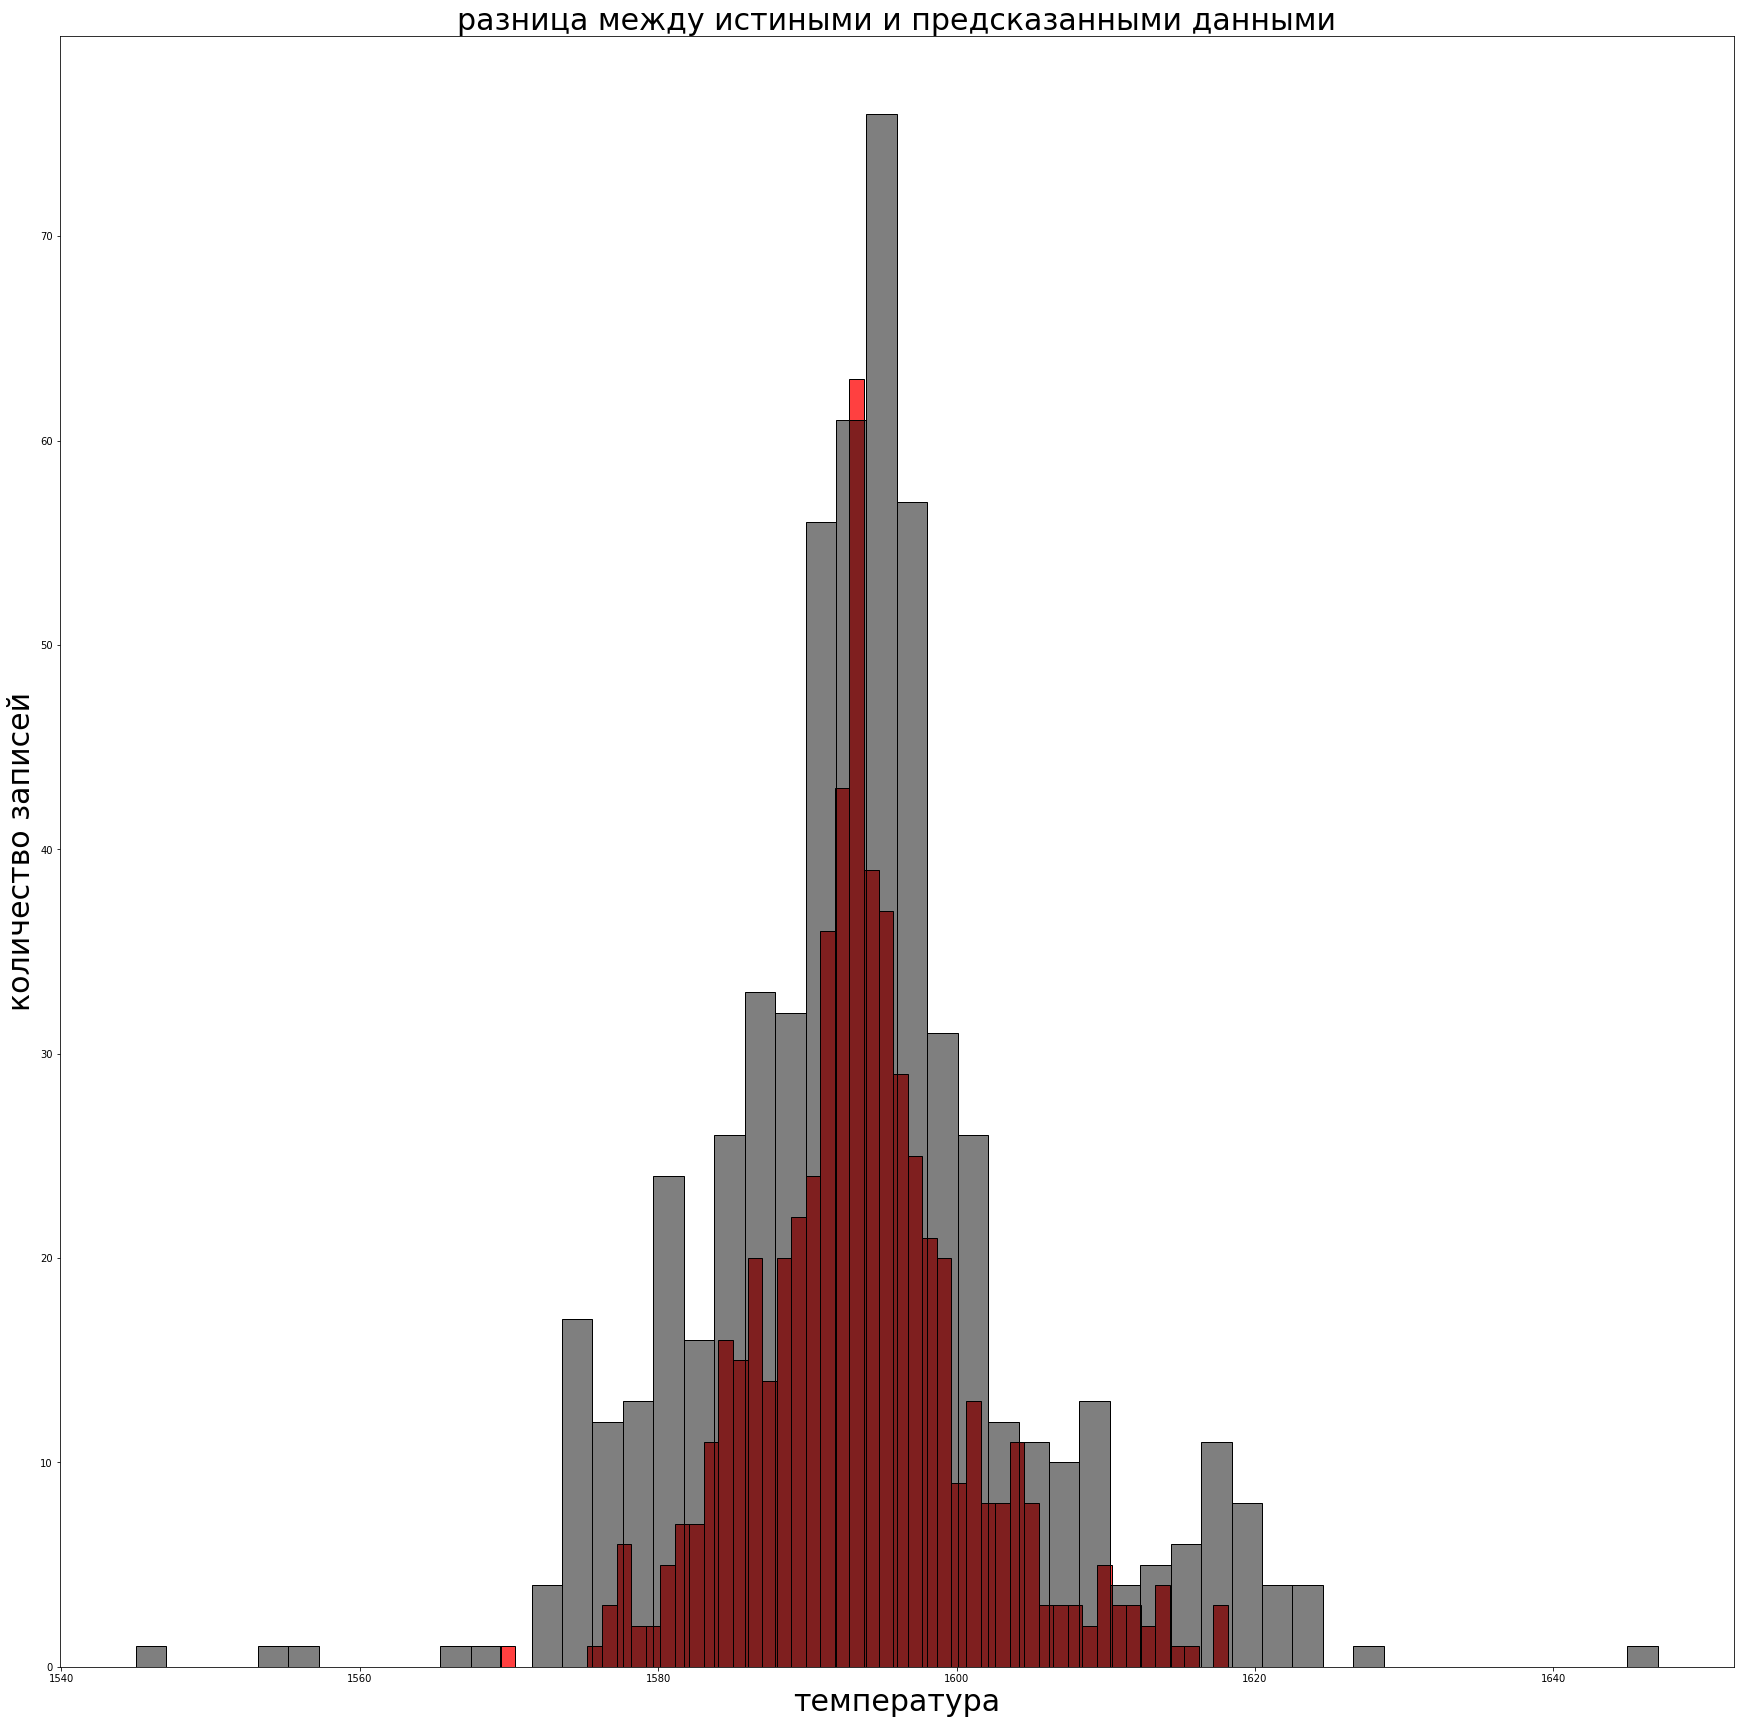

In [96]:
plt.figure(figsize=(30, 30))

sns.histplot(pred, color='red',bins=50)
sns.histplot(y_test,color='black',alpha=0.5,bins=50)

plt.title('разница между истиными и предсказанными данными',size=30)
plt.xlabel('температура',size=30)
plt.ylabel('количество записей',size=30);

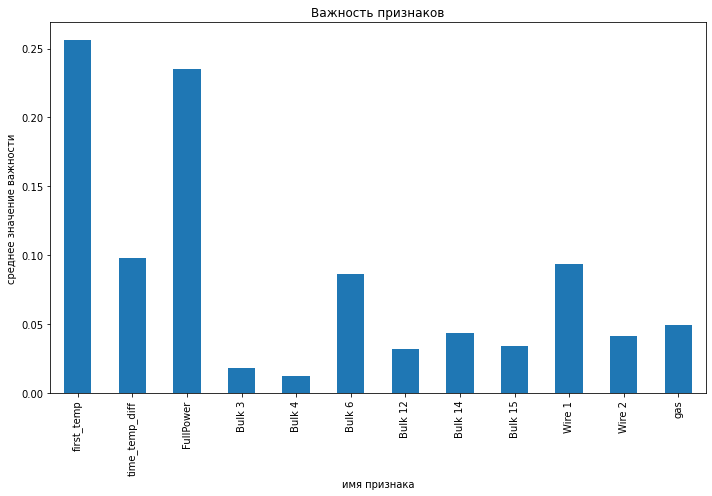

In [97]:
feature_names = features.columns
importances = best_model_RF.feature_importances_
model_importances = pd.Series(importances, index=feature_names)

std = np.std([best_model_RF.feature_importances_ for tree in str(1000)], axis=0)

fig, ax = plt.subplots(figsize=(10,7))
model_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel("среднее значение важности")
ax.set_xlabel("имя признака")
fig.tight_layout()

<div style="padding: 30px 25px; border: 3px #7AD1FF solid">
    
<p style="font-weight: bold; text-align: center;"> вывод <p>
    
- протестировали лучшую модель и сравнили её с константной моделью по метрике R2 и MAE.
    - MAE у рандом форест (лучшая модель) оказалось меньше (значит лучше)
    - R2 у рандом форест (лучшая модель) оказалось больше (значит лучше)
    - также R2 у обеих моделей меньше 1 и не равна 0 это значит, что они работают правильно
    
- модель рандом фореста показал хороший результат:
    - MAE:  5.75
    - R2:   0.42
    
---
<p style="font-weight: bold; text-align: center;"> анализ важности признаков для обучения модели <p>
    
- самым важным признаком оказалась первая температура 
- второй по важности признак, но не менее важным, чем первый это полная мощность ( не удивительно т.к. вполне логично, что чем больше подать мощности на электроды тем выше получиться выходная температура и быстрее расплавится металл)
- третий по важности признак это разница во времени и температуре (time_temp_diff)
- четвертое место поделили 2 признака это присадочный материал 6 и проволока 1

- самыми мало значемыми признаками стали: присадочный материал 3 и присадочный материал 4 ( в них довольно много пропусков было по этому это было ожидаемо)

<div style="font-size:30px ;padding: 30px 25px; background-color:#7AD1FF ;solid;font-weight:400">
<p style="font-weight: bold; text-align: center;"> Глава 5. Общий вывод

<div style=" padding: 30px 25px; border: 3px #FFBF73 solid">
    
__Цель__:

На основании данных о процессе нагрева стали (температуры сплава на различных этапах нагрева, добавленные добавки в сплав, объем использованного газа), необходимо было построить модель, которая предскажет температуру нагрева сплава стали на финальном этапе, с показателем метрики MAE <= 6.8

__Выполненные шаги__:

- Данные были очищены от нерелевантных значений, пропуски заполнены, аномалии проанализированы
- Проведен графический, корелляционный и аналитический анализ данных
- Созданы дополнительные признаки на основе имеющихся данных
- Построены модели - линейная регрессия, случайный лес, полносвязная нейроная сеть, CatBoost
- лучшее значение метрики дала модель  RandomForest MAE:(3.28)

__Результат проверки модели на тестовой выборке__:

- модель не показала существенного ухудшения метрики на тестовой выборке (5,75), R2(0,42)
- лучшая модель была сравнена с константной моделью тем самым доказав свою работоспособность
- был построен график на котором нагрядно видно истинные значения и предсказанные

__рекомендации заказчику по улучщению модели__:
- привести БД в порядок и убрать лишние записи по подаче материала и проволоки
- посмотреть целостность оборудования для измерения показателей
- также стоит обратить пристальное внимание на пораметры реактивной и активной мощьности т.к. судя по данным там твариться чтото странное.

__Итоговый вывод__:
- разработанная модель  удовлетворяет запросу заказчика, по этому ее смело можно внедрить в технологический процесс и начать экономить электро энергию.